In [ ]:
!pip install yfinance

In [ ]:
# In[Imports]

import yfinance as yf
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam, RMSprop
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


In [ ]:
# In[Parameters]

#define the ticker symbol
ticker_symbols = ['TSLA','GOOG','AMZN','AAPL']

#number of days
window_size = 365

#split ratio points of dataset
train_stop = 0.7
test_start = 0.9

#number of training cycles/iterations
epoch = 15

#early staopping trigger
wait = 20

#training cycles before weights are updated
batch = 1

#how many epochs between checking validation data
val_freq = 1

#classification or regression
classification = True

#percent change margin
buy_margin = 0.03
sell_margin = 0.01


In [ ]:
# In[Create DataFrame]

df_dict = {}
for symbol in ticker_symbols:
    #get data on each ticker
    ticker_data = yf.Ticker(symbol)
    
    #get the historical prices for each ticker
    df_dict[symbol] = ticker_data.history(period='1d', start='2010-1-1', end='2021-1-1')

#make dataframe
data = pd.concat(df_dict, axis = 1)

#replace nans with zeros
data = data.fillna(0)


In [ ]:
# In[Create Targets]

target = {}
for i in range(data.shape[0] - 1):
    closes = []
    for ticker in ticker_symbols:
        closes.append(data[(ticker, 'Close')][i + 1])
    target[data.index[i]] = closes

#create dataframe of targets
target = pd.DataFrame.from_dict(target ,orient = 'index', columns = ticker_symbols)

#make targets classes
if classification:
    for i in range(data.shape[0] - 1):
        for ticker in ticker_symbols:
            final = target[ticker][i]
            initial = data[(ticker, 'Close')][i]
            if initial == 0:
                initial = 0.000001
            if ((final - initial) / initial) >= buy_margin:
                target[ticker][i] = 0  #BUY
            elif ((final - initial) / initial) <= sell_margin:
                target[ticker][i] = 1  #SELL
            else:
                target[ticker][i] = 2  #HOLD

#drop last day, since we don't know the closing for tomorrow
data = data[: -1]

print(target)

            TSLA  GOOG  AMZN  AAPL
2010-01-04   1.0   1.0   1.0   1.0
2010-01-05   1.0   1.0   1.0   1.0
2010-01-06   1.0   1.0   1.0   1.0
2010-01-07   1.0   2.0   2.0   1.0
2010-01-08   1.0   1.0   1.0   1.0
...          ...   ...   ...   ...
2020-12-23   2.0   1.0   1.0   1.0
2020-12-24   1.0   2.0   0.0   0.0
2020-12-28   1.0   1.0   2.0   1.0
2020-12-29   0.0   1.0   1.0   1.0
2020-12-30   2.0   1.0   1.0   1.0

[2768 rows x 4 columns]


In [ ]:
# In[Normalize Data]

n = len(data)

scaler = MinMaxScaler()
scaler.fit(data[0 : int(n * train_stop)])
scaled_data = scaler.transform(data)


In [ ]:
# In[Create Windows]

x = []
y = []

#goes from end of first window to end of data
for i in range(window_size, scaled_data.shape[0]):
    x.append(scaled_data[i - window_size : i])
    y.append(target[i : i + 1])
    
x = np.array(x)
y = np.array(y)

print(y)

[[[1. 1. 1. 1.]]

 [[1. 1. 2. 1.]]

 [[1. 1. 1. 1.]]

 ...

 [[1. 1. 2. 1.]]

 [[0. 1. 1. 1.]]

 [[2. 1. 1. 1.]]]


In [ ]:
# In[Split Data]

#same names of labels
#data_column_indices = {name : i for i, name in enumerate(scaled_data.columns)}
#target_column_indices = {name : i for i, name in enumerate(scaled_target.columns)}

n = x.shape[0]

x_train = x[0 : int(n * train_stop)]
x_val = x[int(n * train_stop) : int(n * test_start)]
x_test = x[int(n * test_start) :]

y_train = y[0 : int(n * train_stop)]
y_val = y[int(n * train_stop) : int(n * test_start)]
y_test = y[int(n * test_start) :]

num_features = scaled_data.shape[1]


In [ ]:
# In[Create Model]

model = Sequential([
                    LSTM(units = 32, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])),
                    Dropout(0.2),
                          
                    #Bidirectional(LSTM(units = 32, return_sequences = True)),
                    #Dropout(0.2),
                    
                    #Bidirectional(LSTM(units = 32, return_sequences = True)),
                    #Dropout(0.2),
                          
                    LSTM(units = 32, return_sequences = False),
                    Dropout(0.2),
                          
                    Dense(units = len(ticker_symbols), activation='softmax')
                   ])

model.compile(
              #loss = 'mse',
              loss = 'categorical_hinge',
              optimizer = RMSprop(learning_rate = 1e-4),
              #metrics = ['mae']
              metrics = ['accuracy']
             )

model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 365, 32)           7808      
_________________________________________________________________
dropout_16 (Dropout)         (None, 365, 32)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 132       
Total params: 16,260
Trainable params: 16,260
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# In[Train Model]

history = model.fit(
                    x = x_train,
                    y = y_train,
                    epochs = epoch,
                    batch_size = batch,
                    shuffle = False,
                    validation_data = (x_val, y_val),
                    validation_freq = val_freq,
                    callbacks = [EarlyStopping(patience = wait)]
                   )


Epoch 1/15
1682/1682 [==============================] - 42s 24ms/step - loss: 0.0563 - accuracy: 0.2107 - val_loss: 0.0413 - val_accuracy: 0.1958
Epoch 2/15
1682/1682 [==============================] - 40s 24ms/step - loss: 0.0465 - accuracy: 0.1787 - val_loss: 0.0421 - val_accuracy: 0.1958
Epoch 3/15
1682/1682 [==============================] - 40s 24ms/step - loss: 0.0452 - accuracy: 0.1746 - val_loss: 0.0435 - val_accuracy: 0.1958
Epoch 4/15
1682/1682 [==============================] - 40s 24ms/step - loss: 0.0470 - accuracy: 0.1768 - val_loss: 0.0445 - val_accuracy: 0.1958
Epoch 5/15
1682/1682 [==============================] - 40s 24ms/step - loss: 0.0470 - accuracy: 0.1804 - val_loss: 0.0438 - val_accuracy: 0.1958
Epoch 6/15
1682/1682 [==============================] - 40s 24ms/step - loss: 0.0463 - accuracy: 0.1766 - val_loss: 0.0424 - val_accuracy: 0.1958
Epoch 7/15
1682/1682 [==============================] - 40s 24ms/step - loss: 0.0458 - accuracy: 0.1710 - val_loss: 0.0421 -

In [ ]:
# In[Test Model]

model.evaluate(
               x = x_test,
               y = y_test
              )

y_pred = model.predict(x_test)


8/8 [==============================] - 1s 21ms/step - loss: 0.1322 - accuracy: 0.2709


In [ ]:
print(y_test.reshape(y_test.shape[0], y_test.shape[2]))

[[0. 1. 2. 1.]
 [0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [2. 1. 1. 2.]
 [0. 1. 1. 1.]
 [2. 1. 0. 1.]
 [0. 0. 1. 1.]
 [0. 1. 2. 0.]
 [1. 1. 1. 1.]
 [2. 2. 1. 2.]
 [1. 1. 2. 1.]
 [0. 2. 2. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 2.]
 [0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 1. 1. 1.]
 [0. 1. 1. 2.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 2.]
 [1. 1. 1. 1.]
 [1. 2. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 0. 0. 0.]
 [1. 1. 2. 1.]
 [0. 2. 2. 1.]
 [1. 1. 1. 1.]
 [2. 1. 0. 1.]
 [0. 0. 2. 0.]
 [0. 1. 1. 1.]
 [1. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 0. 0. 2.]
 [0. 2. 1. 1.]
 [1. 1. 1. 1.]
 [1. 2. 1. 2.]
 [0. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 1. 1. 1.]
 [1. 2. 2. 2.]
 [0. 1. 1. 1.]
 [0. 1. 0. 2.]
 [0. 0. 0. 0.]
 [2. 1. 2. 1.]
 [2. 1. 0. 1.]
 [2. 2. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 2. 2.]
 [1. 2. 2. 1.]
 [2. 1. 1.

In [ ]:
print(y_pred)

[[4.0954704e-04 5.9674478e-01 2.1713018e-01 1.8571553e-01]
 [4.0935242e-04 5.9669906e-01 2.1728277e-01 1.8560882e-01]
 [4.0890378e-04 5.9675401e-01 2.1716154e-01 1.8567558e-01]
 [4.0787319e-04 5.9686494e-01 2.1690950e-01 1.8581769e-01]
 [4.0810963e-04 5.9674466e-01 2.1720058e-01 1.8564662e-01]
 [4.0828579e-04 5.9664285e-01 2.1742737e-01 1.8552153e-01]
 [4.0914584e-04 5.9664708e-01 2.1744452e-01 1.8549928e-01]
 [4.0905629e-04 5.9665900e-01 2.1765324e-01 1.8527873e-01]
 [4.0873897e-04 5.9663498e-01 2.1757098e-01 1.8538524e-01]
 [4.0864042e-04 5.9646100e-01 2.1755716e-01 1.8557319e-01]
 [4.0796711e-04 5.9618336e-01 2.1815892e-01 1.8524979e-01]
 [4.0679125e-04 5.9665543e-01 2.1725914e-01 1.8567860e-01]
 [4.0613944e-04 5.9643698e-01 2.1768048e-01 1.8547644e-01]
 [4.0660921e-04 5.9612799e-01 2.1839464e-01 1.8507072e-01]
 [4.0761576e-04 5.9598416e-01 2.1850161e-01 1.8510666e-01]
 [4.0577218e-04 5.9740353e-01 2.1793066e-01 1.8426003e-01]
 [4.0495707e-04 5.9683293e-01 2.1859732e-01 1.8416478e-0

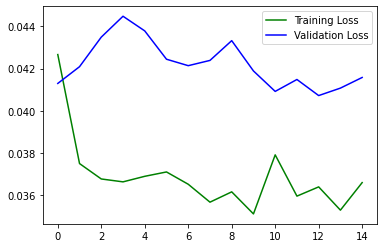

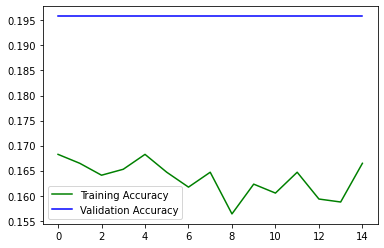

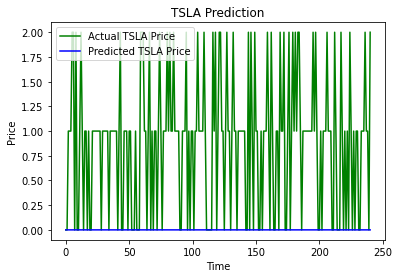

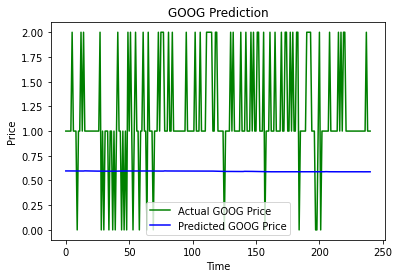

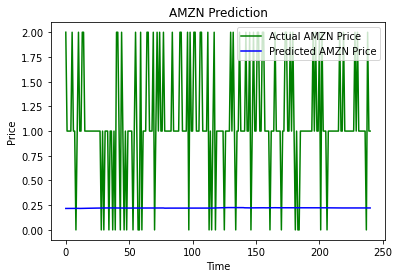

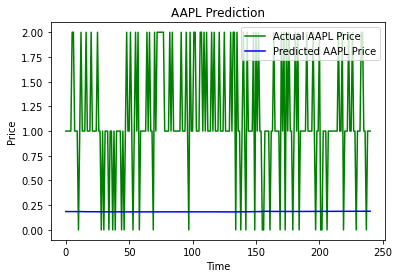

In [ ]:
# In[Graph Results]

#plot loss
plt.plot(
         history.history['loss'],
         label = 'Training Loss',
         color = 'green',
         linestyle = 'solid'
        )

plt.plot(
         history.history['val_loss'],
         label = 'Validation Loss',
         color = 'blue',
         linestyle = 'solid'
        )

plt.legend()
plt.show()

#plot accuracy
plt.plot(

         history.history['accuracy'],
         label = 'Training Accuracy',
         color = 'green',
         linestyle = 'solid'
        )

plt.plot(
         history.history['val_accuracy'],
         label = 'Validation Accuracy',
         color = 'blue',
         linestyle = 'solid'
        )

plt.legend()
plt.show()


#plot stock predictions
y_test_2d = y_test.reshape(y_test.shape[0], y_test.shape[2])
y_pred = np.array(y_pred)

for i in range(len(ticker_symbols)):
    plt.plot(y_test_2d[:, i], color = 'green', label = 'Actual ' + ticker_symbols[i] + ' Price')
    plt.plot(y_pred[:, i], color = 'blue', label = 'Predicted ' + ticker_symbols[i] + ' Price')
    plt.title(ticker_symbols[i] + ' Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()